# Homework 1 - Data mining technology for business and society


The aim of this homework is to configure a search engine on two particular collections of documents: 
* ‘Cranfield’ 
* ‘Time’ 

In particular we want to find the best configuration(in terms of stemming method and scorer function) for the search engine, using the available Ground-Truth data. In order to evaluate the search engine performance I use the precision-at-k metric, P@k.

## Build up the search engine respect to the two collections and evaluate its precision

According to the software I use to do it, I need to use the command line. Here the necessary code follows.

* First of all I set the class-path that once set up allows me to use the software and define some useful variables.

* Then I define the loop to authomatically:
    - Create a collection on the set of html documents with MG4J;
    - Create an inverted index (with MG4J) on the collection trying different stemming methods;
    - Obtain results for each query trying different scorer functions: CountScorer, TfIdfScorer and BM25Scorer;
    - Use the Ground-Truth to evaluate the performance of each stemmer-scorer configuration.

#### How to run the script below

To run the bash script be sure to be located in the folder that contains the following documents:
* The Cranfield_DATA folder
* The Homework_1_software folder
* The Time_DATA folder
* The 'patkpython.py' : that is the Python script that is directly executed using the command line

In [ ]:
%%sh
source set-my-classpath.sh
dataset=("Cranfield" "Time")
stemmers=("--downcase" "it.unimi.di.big.mg4j.index.snowball.EnglishStemmer" "homework.EnglishStemmerStopwords")
scorers=("CountScorer" "TfIdfScorer" "BM25Scorer")
name=("cran" "time")
i=0
for ds in ${dataset[@]};
do
        mv "$ds"_DATASET/${name[$i]}_all_queries.tsv "$ds"_DATASET/"$ds"_all_queries.tsv
        mv "$ds"_DATASET/${name[$i]}_Ground_Truth.tsv "$ds"_DATASET/"$ds"_Ground_Truth.tsv
        echo "Do computations on $ds"
        for st in ${stemmers[@]};
        do
            mkdir "$ds"_DATASET/"$ds"_"$st"
            echo "Build collection"
            find "$ds"_DATASET -iname \*.html | java it.unimi.di.big.mg4j.document.FileSetDocumentCollection -f HtmlDocumentFactory -p encoding=UTF-8 "$ds"_DATASET/"$ds"_"$st"/"$ds".collection
            for sc in ${scorers[@]};
            do 
                echo " Stemmer $st : "
                mkdir "$ds"_DATASET/"$ds"_"$st"/"$st"_"$sc"
                echo " Build the index using $st : "
                if [ "$st" == "${stemmers[0]}" ];
                then java it.unimi.di.big.mg4j.tool.IndexBuilder $st -S "$ds"_DATASET/"$ds"_"$st"/"$ds".collection "$ds"_DATASET/"$ds"_"$st"/"$ds";
                else java it.unimi.di.big.mg4j.tool.IndexBuilder -t $st -S "$ds"_DATASET/"$ds"_"$st"/"$ds".collection "$ds"_DATASET/"$ds"_"$st"/"$ds";
                fi;                
                echo "Run all queries and score them using $sc:"
                java homework.RunAllQueries_HW "$ds"_DATASET/"$ds"_"$st"/"$ds" "$ds"_DATASET/"$ds"_all_queries.tsv "$sc" "1:2" "$ds"_DATASET/"$ds"_"$st"/"$st"_"$sc"/output_"$st"_"$sc".tsv 
                echo "Execute the Python script to evaluate the extended precision of the search engine:"
                python patkpython.py $st $sc $ds
            done
        done
        ((i++))
done
echo "Finish, let’s plot our result!"

To determine the average P@k over all queries in the query set, taking in input the search engine results for each query in the query set and the Ground-Truth file. I write a software in Python that is saved in the folder as 'patkpython.py'. It is directly executed in the above piece of code. 

According to the script I would like to stress that I define the precision of the search engine respect to the queries and k as follows:

Given
* RetrD_k : the set of retrieved document( up to k) by the engine to answer a query;
* RelD : the set of relevant document to answer the query;
* k : number of retrieved document taken into account

In [69]:
%%latex
$$P@k = \frac{RetrD \bigcap RelD}{min\{k, RelD\}}$$

<IPython.core.display.Latex object>

I divide by the minimun in order to get precision equal to 1 whether, in the set of retrieved documents there are all those that are also in the relevant document set and the number of that documents is smaller that k. If I don't divide by the minimum I would get a value smaller than 1 that would not describe the "real" precision of the search engine that concretely gives back all the documents considered relevant.

There is also another important consideration to do, it is related to the fact that not to all queries correspond a set of relevant document. To handle this inconsistency I take into consideration only the queries for which I have a Ground Truth.

### Once we get the results.. Plot them to see how the story ends!

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
%matplotlib inline  

In [13]:
# Define variables to define the files I want to load
dataset=["Cranfield", "Time"]
stemmers=["--downcase", "it.unimi.di.big.mg4j.index.snowball.EnglishStemmer", "homework.EnglishStemmerStopwords"]
scorers=["CountScorer", "TfIdfScorer", "BM25Scorer"]
colours = ['Red','Darkred','Pink','DeepPink','Lime','Coral','Olive','SteelBlue','Yellow','Orange']
k = [1,3,5,10]
x = np.array([0,1,2,3])

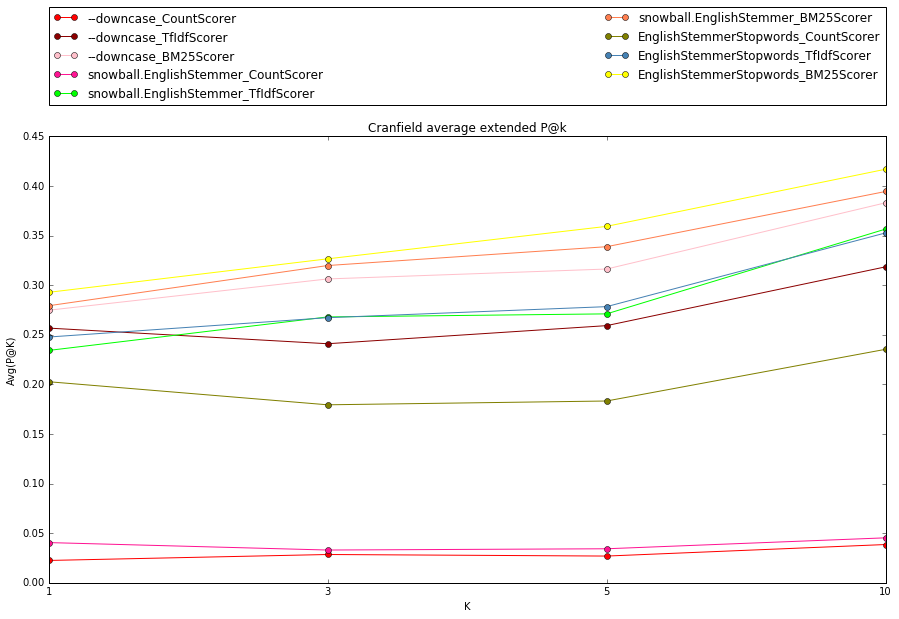

In [14]:
# Plot the results of Cranfield
plt.figure(figsize=(15,8), dpi=80)
i = 0
for s in stemmers:
    for sc in scorers:
        avg_pre = pickle.load(open(str(dataset[0])+'_DATASET/'+str(dataset[0])+'_'+str(s)+'/'+str(dataset[0])+'_'+str(sc)+'avg_'+str(s)+'_'+str(sc)+'.p', 'rb'))
        # Get the values to plot
        values = [avg_pre[l] for l in sorted(avg_pre.keys())]
        if str(s) == "--downcase":
            plt.plot(values, marker = 'o', color=colours[i], linestyle = '-', label=str(s)+'_'+str(sc))
        else:
            plt.plot(values, marker = 'o', color=colours[i],linestyle = '-', label=str(s)[-23:]+'_'+str(sc))
        plt.ylabel('Avg(P@K)')
        plt.xlabel('K')
        plt.legend(bbox_to_anchor=(0., 1.07, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        i += 1
plt.xticks(x, k)
plt.title('Cranfield average extended P@k')
plt.show()

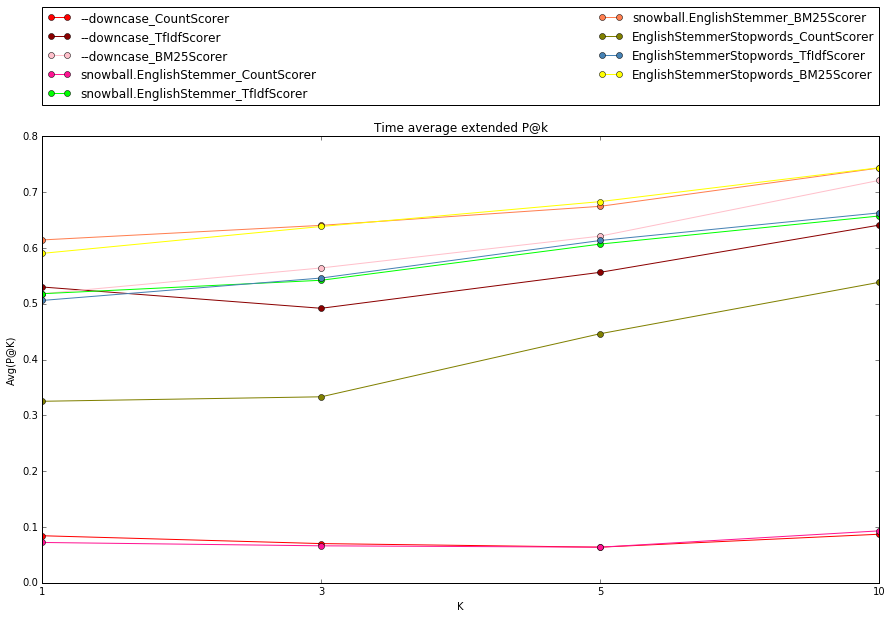

In [20]:
# Plot the results of Time
plt.figure(figsize=(15,8), dpi=80)
i = 0
for s in stemmers:
    for sc in scorers:
        avg_pre = pickle.load(open(str(dataset[1])+'_DATASET/'+str(dataset[1])+'_'+str(s)+'/'+str(dataset[1])+'_'+str(sc)+'avg_'+str(s)+'_'+str(sc)+'.p', 'rb'))
        # Get the values to plot
        values = [avg_pre[l] for l in sorted(avg_pre.keys())]
        if str(s) == "--downcase":
            plt.plot( values, marker = 'o', color=colours[i], linestyle = '-', label=str(s)+'_'+str(sc))
        else:
            plt.plot( values, marker = 'o', color=colours[i],linestyle = '-', label=str(s)[-23:]+'_'+str(sc))
        plt.ylabel('Avg(P@K)')
        plt.xlabel('K')
        plt.legend(bbox_to_anchor=(0., 1.07, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
        i += 1
plt.xticks(x, k)
plt.title('Time average extended P@k')
plt.show()

### Statistics on Cranfield 

1. (a) The number of documents that composed the Crafield dataset is:

In [16]:
import os
print len(os.listdir('Cranfield_DATASET/cran'))

1400


1. (b) The number of queries is:

In [17]:
len(set(np.array(pd.read_csv('Cranfield_DATASET/Cranfield_--downcase/--downcase_BM25Scorer/output_--downcase_BM25Scorer.tsv', sep = '\t'))[:,0]))

225

### Statistics on Time

1. (a) The number of documents that composed the Crafield dataset is:

In [18]:
print len(os.listdir('Time_DATASET/time'))

424


1. (b) The number of queries is:

In [19]:
len(set(np.array(pd.read_csv('Time_DATASET/Time_--downcase/--downcase_BM25Scorer/output_--downcase_BM25Scorer.tsv', sep = '\t'))[:,0]))

83